Vanila GAN for 1d task


In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.utils.data as data
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def generate_1d_data(count):
  gaussian1 = np.random.normal(loc=-1, scale=0.25, size=(count // 2,))
  gaussian2 = np.random.normal(loc=0.5, scale=0.5, size=(count // 2,))
  data = (np.concatenate([gaussian1, gaussian2]) + 1).reshape([-1, 1])
  return (data - data.min()) / (data.max() - data.min())


def visualize_1d_data(data):
  plt.figure(figsize=(7, 4))
  plt.hist(data, bins=50)
  plt.show()

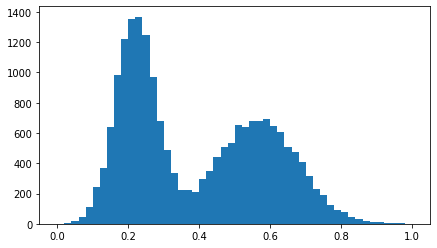

In [5]:
COUNT = 20000

train_data = generate_1d_data(COUNT)
visualize_1d_data(train_data)


In [6]:
class FullyConnectedMLP(nn.Module):
  def __init__(self,input_dim,hiddens,output_dim):
    assert isinstance(hiddens,list)
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.hiddens = hiddens

    model = []
    layers = [input_dim] + hiddens + [output_dim]
    for current_layer, next_layer in zip(layers, layers[1:]):
      model.extend([ nn.Linear(in_features = current_layer,out_features = next_layer),  nn.ELU() ])
    model.pop() # to remove the final nn.ELU()
    self.net = nn.Sequential(*model)

  def forward(self,x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    return self.net(x).view(batch_size, self.output_dim)


In [7]:
class MLPDiscriminator(nn.Module):
  def __init__(self, latent_dim, hiddens, data_dim):
    super().__init__()
    self.mlp = FullyConnectedMLP(latent_dim, hiddens, data_dim)
    
  def forward(self, z):
    # apply mlp and sigmoid activation
    return torch.sigmoid(self.mlp(z)) 

In [8]:
class MLPGenerator(nn.Module):
  def __init__(self, latent_dim, hiddens, data_dim):
    super().__init__()
    self.latent_dim = latent_dim
    self.mlp = FullyConnectedMLP(latent_dim, hiddens, data_dim)
    
  def forward(self, z):
    # apply mlp and sigmoid activation
    # ?? sigmoid activation, but why ?? 
    return self.mlp(z)
        
  def sample(self, n):
    # sample from uniform and apply the model
    assert isinstance(n,int)
    z = torch.rand((n,1))
    x = self.mlp(z)
    return x

In [9]:
BATCH_SIZE = 5
GEN_HIDDENS = [4,8,16]
DISCR_HIDDENS = [4,8,16]
EPOCHS = 2
LR = 1e-3
DISCR_STEPS = 4

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# model
generator = MLPGenerator(latent_dim=1, hiddens=GEN_HIDDENS, data_dim=1)#.cuda()
discriminator = MLPDiscriminator(latent_dim=1, hiddens=DISCR_HIDDENS, data_dim=1)#.cuda()


def gen_loss(generator, discriminator, x):
  # sample data from generator (number of samples = x.shape[0])
  fake_data = generator.sample(x.shape[0])
  return   torch.mean(torch.log(1 - discriminator(fake_data)))    # log(1 - D(x))


def discr_loss(generator, discriminator, x):
  # sample data from generator (number of samples = x.shape[0])
  fake_data = generator.sample(x.shape[0])

  return  - torch.mean(torch.log(discriminator(x)) + torch.log(1 - discriminator(fake_data))) # - log(D(x_real))- log(1 - D(x_fake))


In [10]:
def plot_gan_training(losses, title):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

In [11]:
def make_step(loss_fn, x, generator, discriminator, optimizer):
    loss = loss_fn(generator, discriminator, x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [12]:
def train_epoch(
    generator, 
    discriminator, 
    gen_loss_fn, 
    discr_loss_fn, 
    train_loader, 
    gen_optimizer, 
    discr_optimizer, 
    discr_steps=1
):
    generator.train()
    discriminator.train()

    gen_losses, discr_losses = [], []
    for idx, x in enumerate(train_loader):
        x = x.float()
        discr_loss = make_step(discr_loss_fn, x, generator, discriminator, discr_optimizer)
        discr_losses.append(discr_loss.item())

        if idx % discr_steps == 0:
            gen_loss = make_step(gen_loss_fn, x, generator, discriminator, gen_optimizer)
            gen_losses.append(gen_loss.item())
    return {
        'generator_losses': gen_losses,
        'discriminator_losses': discr_losses
    }


In [13]:
def train_model(
    generator, 
    discriminator, 
    gen_loss_fn, 
    discr_loss_fn, 
    train_loader, 
    epochs,
    lr,
    discr_steps=1
):
    gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    discr_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0, 0.9))

    train_losses = {}
    for epoch in range(epochs):
        train_loss = train_epoch(
            generator, 
            discriminator, 
            gen_loss_fn, 
            discr_loss_fn,
            train_loader, 
            gen_optimizer, 
            discr_optimizer, 
            discr_steps=discr_steps
        )
        
        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])

    return train_losses

In [18]:
# train
train_losses = train_model(
    generator, 
    discriminator, 
    gen_loss, 
    discr_loss, 
    train_loader, 
    epochs=EPOCHS,
    lr=LR,
    discr_steps=DISCR_STEPS
)

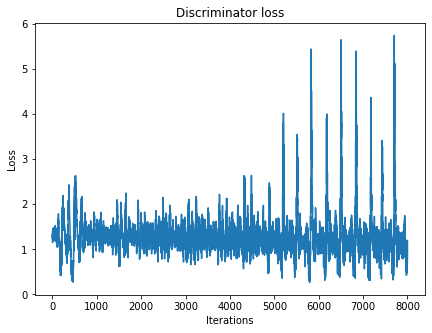

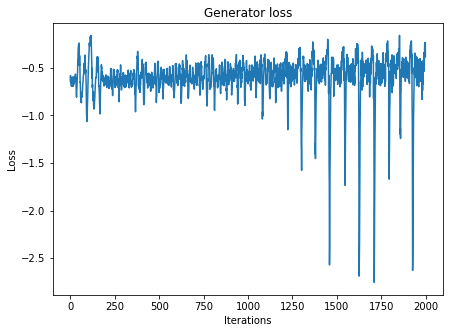

In [19]:
plot_gan_training(train_losses['discriminator_losses'], 'Discriminator loss')
plot_gan_training(train_losses['generator_losses'], 'Generator loss')


In [20]:
def make_inference(generator, discriminator, n_samples=5000):
    generator.eval()
    discriminator.eval()
    xs = np.linspace(0, 1, 1000)
    samples = generator.sample(n_samples).cpu().detach().numpy()
    discr_output = discriminator(torch.FloatTensor(xs).unsqueeze(1)).cpu().detach().numpy()
    return samples, xs, discr_output


def plot_results(data, samples, xs, ys, title):
    plt.figure(figsize=(7, 5))
    plt.hist(samples, bins=50, density=True, alpha=0.7, label='fake')
    plt.hist(data, bins=50, density=True, alpha=0.7, label='real')

    plt.plot(xs, ys, label='discrim')
    plt.legend()
    plt.title(title)

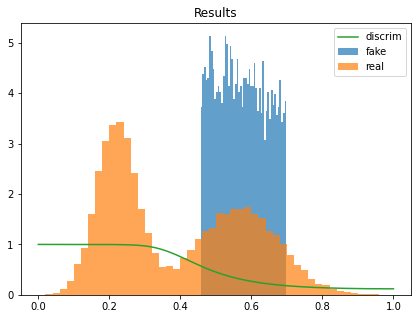

In [21]:
samples, xs, discr_output = make_inference(generator, discriminator)
plot_results(train_data, samples, xs, discr_output, 'Results')

In [22]:
BATCH_SIZE = 5
GEN_HIDDENS = [4,8,16]
DISCR_HIDDENS = [4,8,16]
EPOCHS = 2
LR = 1e-3
DISCR_STEPS = 4


train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# model
generator = MLPGenerator(latent_dim=1, hiddens=GEN_HIDDENS, data_dim=1)#.cuda()
discriminator = MLPDiscriminator(latent_dim=1, hiddens=DISCR_HIDDENS, data_dim=1)#.cuda()


def gen_loss(generator, discriminator, x):
    # sample data from generator (number of samples = x.shape[0])
    fake_data = generator.sample(x.shape[0])
    return -torch.mean(torch.log(discriminator(fake_data)))# -log(D(x))


# train
train_losses = train_model(
    generator, 
    discriminator, 
    gen_loss, 
    discr_loss, 
    train_loader, 
    epochs=EPOCHS,
    lr=LR,
    discr_steps=DISCR_STEPS
)

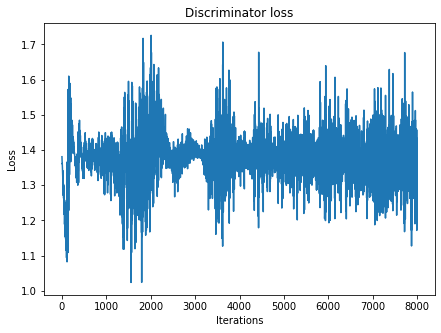

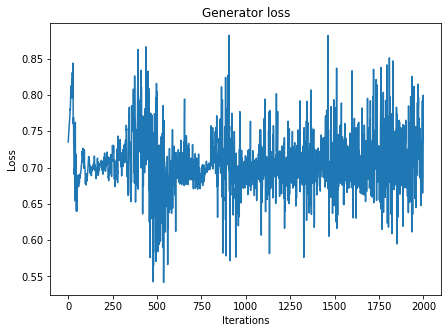

In [23]:
plot_gan_training(train_losses['discriminator_losses'], 'Discriminator loss')
plot_gan_training(train_losses['generator_losses'], 'Generator loss')

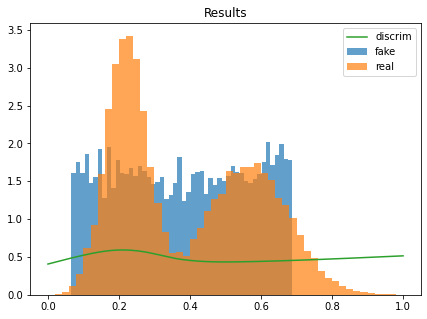

In [24]:
samples, xs, discr_output = make_inference(generator, discriminator)
plot_results(train_data, samples, xs, discr_output, 'Results')